# Universal Studios Reviews - EDA

## 1. Import Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# text data
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import string

# sentiment analysis
from textblob import TextBlob
from wordcloud import WordCloud

## 2. Data Wrangling

### Read Data

In [2]:
df = pd.read_csv('../input/reviewuniversalstudio/universal_studio_branches.csv', encoding = 'UTF-8')
df.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [3]:
df.isnull().sum()

reviewer        0
rating          0
written_date    0
title           0
review_text     0
branch          0
dtype: int64

### Change Data Type

In [4]:
df.dtypes

reviewer         object
rating          float64
written_date     object
title            object
review_text      object
branch           object
dtype: object

From the information above we should change data type of `written_date` into datetime64

In [5]:
df['written_date'] = pd.to_datetime(df['written_date'])
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                  object
dtype: object

In [6]:
df.nunique()

reviewer        44086
rating              5
written_date     4276
title           37522
review_text     50847
branch              3
dtype: int64

Also we need to change `branch` into category data type

In [7]:
df['branch'].unique()

array(['Universal Studios Florida', 'Universal Studios Japan',
       'Universal Studios Singapore'], dtype=object)

In [8]:
df['branch'] = df['branch'].astype('category')
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                category
dtype: object

### Removing Duplicates Data

In [9]:
df.shape

(50904, 6)

**We have 50,904 rows and 6 columns.**<br><br>
For the further analysing the duplicate data, in this case is `review_text` indicate that they also contain the same information in other columns too. So wee need to drop the duplicate and keeping first.

In [10]:
df.drop_duplicates(subset='review_text', inplace=True, keep='first')
df.shape

(50847, 6)

### Data Summary

In [11]:
print ("Number of Rows     :" ,df.shape[0])
print ("Number of Columns  :" ,df.shape[1])
print ("\nFeatures         :\n" ,list(df.columns))
print ("\nMissing values   :", df.isnull().sum().sum())
print ("\nUnique values    :\n",df.nunique())
print ("\nBranches Reviews :\n",df['branch'].value_counts())

Number of Rows     : 50847
Number of Columns  : 6

Features         :
 ['reviewer', 'rating', 'written_date', 'title', 'review_text', 'branch']

Missing values   : 0

Unique values    :
 reviewer        44082
rating              5
written_date     4276
title           37517
review_text     50847
branch              3
dtype: int64

Branches Reviews :
 Universal Studios Florida      30582
Universal Studios Singapore    15738
Universal Studios Japan         4527
Name: branch, dtype: int64


There is some bias in the data to Branches feature value counts aren't fairly distributed

## 3. Feature Engineering

### Get Period Information of `written_date`

In [12]:
df['quarter'] = df['written_date'].dt.to_period('Q')
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2


### Get Review Length Feature of `written_text`

In [13]:
df['review_text'].values[4:5]

array(["Ok, I can't stress enough to anyone and everyone... if you go to Universal Studios Orlando... make sure you take the time to go see The Bourne Stuntacular...I had to watch it 3xs and it wasn't enough. I never knew who Jason Bourne was... but now I will be buying the movies. This was absolutely awesome, amazing and 100% worth the entire cost of the trip by itself. So worth the wait and every time I went it was packed. I would have passed it up thinking it was nothing WRONG!!!! ...DONT MISS THIS!!!!"],
      dtype=object)

### Get Sentiment Analysis Feature

Let's clean the `review_text` column first by define a function:

In [14]:
def text_clean(text):
    # case folding
    text = text.lower()
    
    ## Decontract text            
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"\'t've", " not have", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'clock", "f the clock", text)
    text = re.sub(r"\'cause", " because", text)
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    
    # remove all puctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # text = re.sub('\w*\d\w*', '', text) #remove digit/number
    
    # remove all special characters
    text = re.sub(r'\W', ' ', text)

    # remove break
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    
    # remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

In [15]:
df_text = pd.DataFrame()
df_text['clean_review_text'] = df['review_text'].apply(lambda x: text_clean(x))

Let's check before and after cleansing

In [16]:
df.loc[44,'review_text']

'✅ $850💵 + ⏰ hours of high heat 91 degrees🔥 & 😷☀️. We were shocked to be in long lines walking about 7.5 miles for the day masked up! Like sheep 🐑 being threatened constantly with loud speaker 🔈announcements demanding no drinking 🥤or eating while walking 🚶\u200d♀️& maintain social distancing, wearing a mask at all times or being 👢booted from the park. I saw kids 👆touching all handrails and then putting hands in their parents cups eating ice and then the parents gulping down the remainder(at $10 per beverage can you blame them) 🤷\u200d♂️ confused I do thousands of people show up to spend 💰💰💰💰💰💰if they are paranoid of public places! Universal Studios is a germs 🦠 paradise! They also pray on people’s wallets with the nifty reservation system it allows them to supply and demand fast passes from $80 extra to $249 demanding on all the variables they control! We despised being ordered around with lousy customer service! Constant loud interruptions🛑 during the rides 🎢demanding guests wear a ma

In [17]:
df_text.loc[44,'clean_review_text']

' 850 hours of high heat 91 degrees we were shocked to be in long lines walking about 75 miles for the day masked up like sheep being threatened constantly with loud speaker announcements demanding no drinking or eating while walking maintain social distancing wearing a mask at all times or being booted from the park i saw kids touching all handrails and then putting hands in their parents cups eating ice and then the parents gulping down the remainderat 10 per beverage can you blame them confused i do thousands of people show up to spend if they are paranoid of public places universal studios is a germs paradise they also pray on people is wallets with the nifty reservation system it allows them to supply and demand fast passes from 80 extra to 249 demanding on all the variables they control we despised being ordered around with lousy customer service constant loud interruptions during the rides demanding guests wear a mask save yourself the money headaches and do not go it is ridicul

**Sentiment Analysis**<br>
Define function to get the subjectivity and polarity of text

In [18]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

create column subjectivity and polarity and sentiment analysis

In [19]:
df_text['subjectivity'] = df_text['clean_review_text'].apply(getSubjectivity)
df_text['polarity'] = df_text['clean_review_text'].apply(getPolarity)
def getsentiment(score):
 if score < 0:
  return 'negative'
 elif score == 0:
  return 'neutral'
 else:
  return 'positive'
df_text['sentiment'] = df_text['polarity'].apply(getsentiment)
df_text.head()

,clean_review_text,subjectivity,polarity,sentiment
0,we went to universal over memorial day weekend...,0.411574,-0.065278,negative
1,the food service is horrible i am not reviewin...,0.425000,-0.262500,negative
2,i booked this vacation mainly to ride hagrid m...,0.494771,-0.004259,negative
3,when a person tries the test seat for the ride...,0.380000,0.010000,positive
4,ok i can not stress enough to anyone and every...,0.546717,0.245455,positive


In [20]:
df_text['sentiment'].value_counts()

positive    46936
negative     3598
neutral       313
Name: sentiment, dtype: int64

Beside, assume that rating below 3.0 is 'negative'

In [21]:
df['sentiment'] = df_text['sentiment']
df['sentiment'] = df['rating'].apply(lambda x: 'negative' if x<3.0 else np.nan)
df['sentiment'] = df['sentiment'].fillna(df_text['sentiment'])
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter,sentiment
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2,negative
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2,negative
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2,negative
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2,positive
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2,positive


In [22]:
df['sentiment'].value_counts()

positive    44587
negative     5987
neutral       273
Name: sentiment, dtype: int64

## 4. Data Analysis and Visualization

### 4.1. Number of Reviews by Visitors of Universal Studios Branches

In [23]:
df.dtypes

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                category
quarter          period[Q-DEC]
sentiment               object
dtype: object

In [24]:
df[['sentiment','quarter']] = df[['sentiment','quarter']].astype('category')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50847 entries, 0 to 50903
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reviewer      50847 non-null  object        
 1   rating        50847 non-null  float64       
 2   written_date  50847 non-null  datetime64[ns]
 3   title         50847 non-null  object        
 4   review_text   50847 non-null  object        
 5   branch        50847 non-null  category      
 6   quarter       50847 non-null  category      
 7   sentiment     50847 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(1), object(3)
memory usage: 4.5+ MB


In [26]:
branch_count = df['branch'].value_counts()
branch_count.to_frame()

,branch
Universal Studios Florida,30582
Universal Studios Singapore,15738
Universal Studios Japan,4527


Text(0, 0.5, 'Number of Reviews')

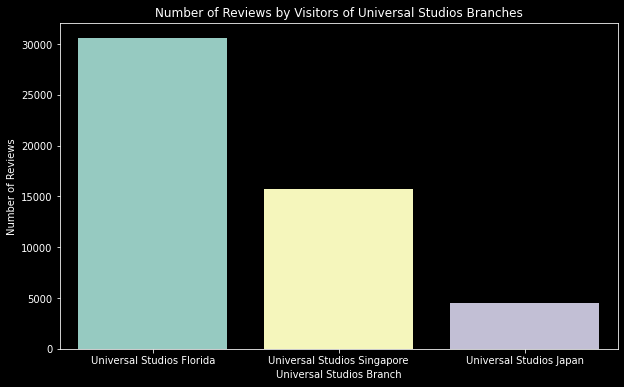

In [27]:
plt.figure(figsize=(10,6))
plt.title('Number of Reviews by Visitors of Universal Studios Branches')
sns.countplot(data=df, x='branch', order=['Universal Studios Florida', 'Universal Studios Singapore', 'Universal Studios Japan'])
plt.xlabel('Universal Studios Branch')
plt.ylabel('Number of Reviews')

### 4.2. Number of Reviews by Visitors of Universal Studios Branches per Year

In [28]:
df['year'] = df['written_date'].dt.year.astype('int64')
df.head()

,reviewer,rating,written_date,title,review_text,branch,quarter,sentiment,year
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021Q2,negative,2021
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021Q2,negative,2021
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021Q2,negative,2021
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021Q2,positive,2021
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021Q2,positive,2021


<AxesSubplot:title={'center':'Number of Reviews by Visitors of Universal Studios Branches per Year'}, xlabel='year', ylabel='count'>

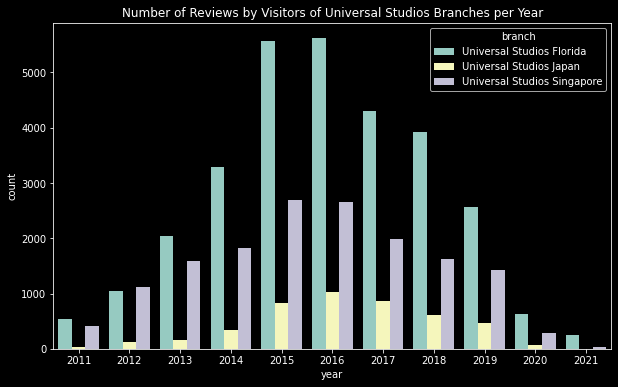

In [29]:
plt.figure(figsize=(10,6))
plt.title('Number of Reviews by Visitors of Universal Studios Branches per Year')
sns.countplot(data=df[df['year']>2010], x='year', hue='branch')

From the visualization above, we can see that from 2011 there was an increase in the number of visitors until 2016. After that, the number of visitors decreased drastically in 2020, considering that this year covid pandemic was spreading all over the world.

### 4.3. Number of Rating per Year

In [30]:
rates_year=df[df['year']>2010].pivot_table(
    index='year',
    columns='rating',
    values='branch',
    aggfunc='count'
).reset_index().melt(id_vars='year')

<AxesSubplot:title={'center':'Number of Rating per Year'}, xlabel='year', ylabel='value'>

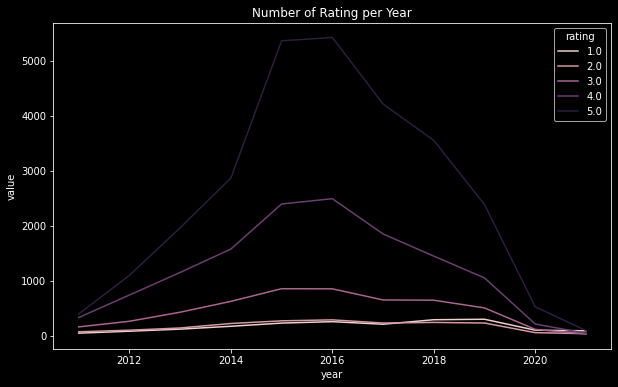

In [31]:
plt.figure(figsize=(10,6))
plt.title('Number of Rating per Year')
sns.lineplot(data= rates_year, x='year', y='value', hue='rating')

From the visualization above, we can see that many reviewers gave 5 stars. This means that the average Universal Studio visitor is satisfied with their visit by giving a 5 rating.

### 4.4. Number of Rating per Branch

<AxesSubplot:title={'center':'Number of Rating per Branch'}, xlabel='branch', ylabel='rating'>

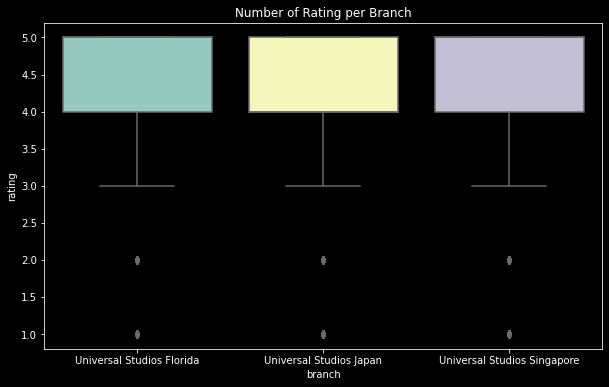

In [32]:
plt.figure(figsize=(10,6))
plt.title('Number of Rating per Branch')
sns.boxplot(data=df, x='branch', y='rating')

### 4.5. Number of Sentiment per Branch

<AxesSubplot:title={'center':'Number of Sentiment per Branch'}, xlabel='branch', ylabel='count'>

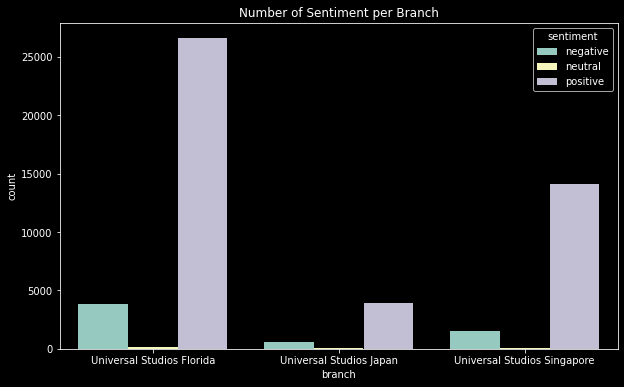

In [33]:
plt.figure(figsize=(10,6))
plt.title('Number of Sentiment per Branch')
sns.countplot(data=df, x='branch', hue='sentiment')

### 4.6. Sentiment Percentage per Branch

In [34]:
sentiment_percent=pd.crosstab(
    index=df['sentiment'],
    columns=df['branch'],
    normalize='columns'
).round(2)
sentiment_percent

branch,Universal Studios Florida,Universal Studios Japan,Universal Studios Singapore
sentiment,,,
negative,0.13,0.13,0.10
neutral,0.00,0.01,0.01
positive,0.87,0.86,0.90


From the information above we can conclude that, the reviews given to Universal Studio are mostly positive reviews from all three branches.

## Sentiment in Reviews

**Positive Review**

In [35]:
df['clean_review_text']=df_text['clean_review_text']

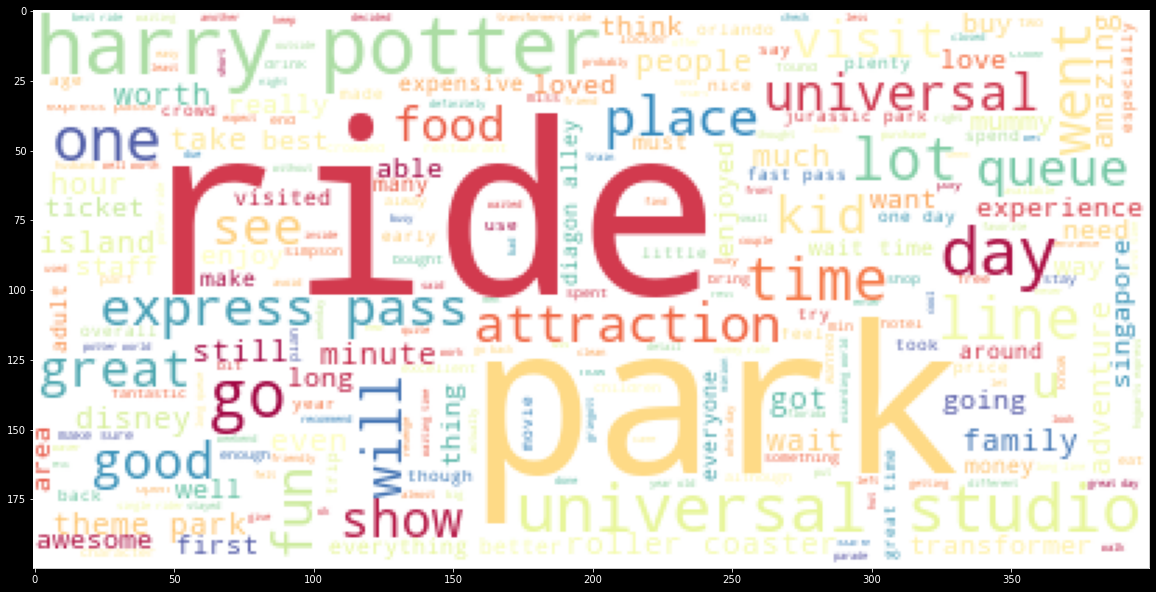

In [36]:
positif_review=df[df['sentiment']=='positive']
review_text = ' '.join(insul for insul in positif_review['clean_review_text'])
word_cloud = WordCloud(
    background_color='white',
    mode='RGB',
    max_words=1000,
    random_state=1,
    colormap='Spectral'
)
word_cloud.generate(review_text)
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)
plt.show()

**Negative Reviews**

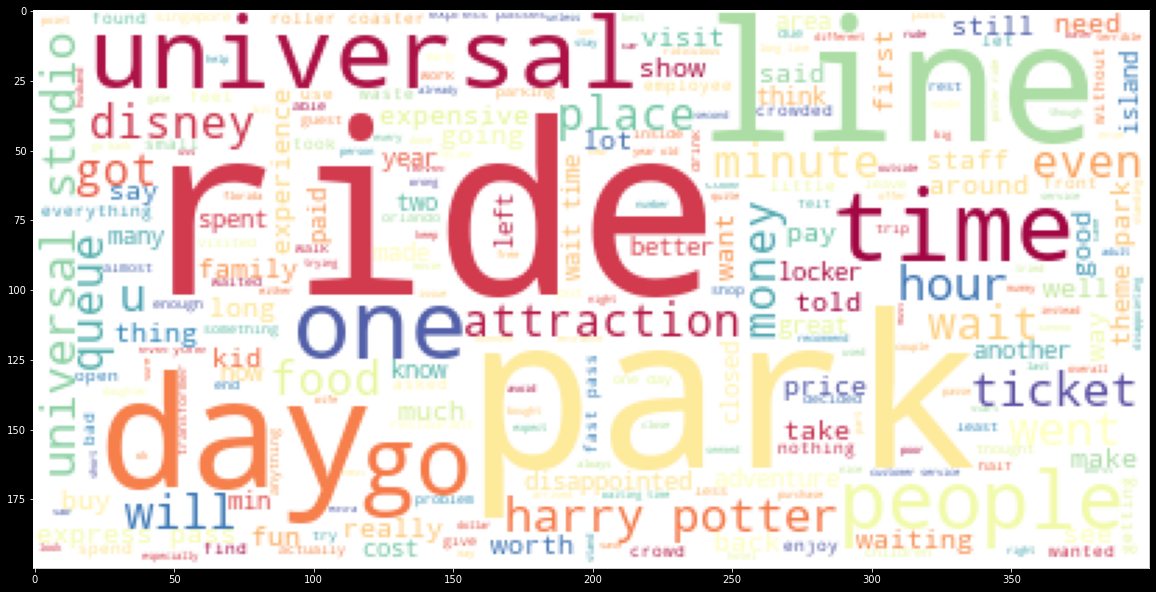

In [37]:
negative_review=df[df['sentiment']=='negative']
review_text = ' '.join(insul for insul in negative_review['clean_review_text'])
word_cloud = WordCloud(
    background_color='white',
    mode='RGB',
    max_words=1000,
    random_state=1,
    colormap='Spectral'
)
word_cloud.generate(review_text)
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)
plt.show()

## Word in Negative Review

In [38]:
negative_review=negative_review['clean_review_text'].drop_duplicates()

all_sentences=[]
for word in negative_review:
    all_sentences.append(word)
    
lines=list()
for line in all_sentences:
    words=line.split()
    for w in words:
        lines.append(w)
        
#==================

lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines
#==================

lines2 = []
for word in lines:
    if word != '':
        lines2.append(word)
#==================
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')

stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

In [39]:
#==================
import spacy
nlp = spacy.load('en_core_web_lg')
stem2 = []

for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)
#==================
df_word = pd.DataFrame(stem2)
df_word = df_word.value_counts()
df_word = df_word[:20,]

In [40]:
#==================
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
#==================
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))
#==================
nlp = spacy.load('en_core_web_sm') 
nlp.max_length = 20000000

In [41]:
#==================
str1 = " " 
stem2 = str1.join(lines2)

In [ ]:
stem2 = nlp(stem2)

In [ ]:
label = [(X.text, X.label_) for X in stem2.ents]

df_words = pd.DataFrame(label, columns = ['Word','Entity'])